In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as Data
from tqdm import tqdm

import numpy as np

In [2]:
USE_CUDA = True

In [3]:
root = '/notebooks/sinica/dataset/'
train_data = root+'facial.train'
dev_data = root+'facial.dev'
test_data = root+'facial.test'

UNKOWN_TAG = "<UNKNOWN>"
PAD_TAG = "<PAD>"
tag_to_ix = {UNKOWN_TAG: 0, PAD_TAG:1, "B-Func": 2, "I-Func": 3, "O": 4}

tagset_size = len(tag_to_ix)
MAX_LEN = 100
BATCH_SIZE = 128

EMBEDDING_DIM = 20
HIDDEN_DIM1 = 10
HIDDEN_DIM2 = 8
LABEL_EMBED_DIM = 3
DENSE_OUT = 100

ATTN_IN = tagset_size+LABEL_EMBED_DIM
ATTN_OUT = 5

In [57]:
def readfile(data):
    with open(data, "r", encoding="utf-8") as f:
        content = f.read().splitlines()
        
    return content

# ==================================================

def get_word_and_label(_content, start_w, end_w):
    word_list = []
    tag_list = []
    for word_set in _content[start_w:end_w]:
        word_list.append(word_set[0])
        tag_list.append(word_set[2:])
    
    return word_list, tag_list

def split_to_list(content):
    init = 0
    word_list = []
    tag_list = []

    for i, c in enumerate(content):
        if c=='':
            words, tags = get_word_and_label(content, init, i)
            init = i+1
            word_list.append(words)
            tag_list.append(tags)
            
    return word_list, tag_list

# ==================================================
    
def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        if w not in to_ix:
            idxs.append(to_ix[UNKOWN_TAG])
        else:
            idxs.append(to_ix[w])
    
#     idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

def prepare_all(seqs, to_ix):
    seq_list = []
    for i in range(len(seqs)):
        seq_list.append(prepare_sequence(seqs[i], to_ix))
        
    seq_list = torch.stack(seq_list)
        
    return seq_list

# ==================================================

def word2index(word_list):
    word_to_ix = {"<UNKNOWN>":0, "<PAD>":1}
    for sentence in word_list:
        for word in sentence:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
                
    return word_to_ix

def dict_inverse(tag_to_ix):
    ix_to_tag = {v: k for k, v in tag_to_ix.items()}
    return ix_to_tag

def index2tag(indexs, ix_to):
    to_tags = [ix_to[i] for i in indexs.cpu().numpy()]
    return to_tags

# ==================================================

def find_max_len(word_list):
    max_len = 0
    for i in range(len(word_list)):
        if max_len<len(word_list[i]):
            max_len=len(word_list[i])
            
    return max_len

# ====== filter the length of sentence more than MAX_LEN =======

def filter_len(word_list):
    reserved_index = []
    for i in range(len(word_list)):
        if len(word_list[i])<MAX_LEN:
            reserved_index.append(i)
            
    return reserved_index


def filter_sentence(reserved_index, word_list, tag_list):
    filter_word = list(word_list[i] for i in reserved_index)
    filter_tag = list(tag_list[i] for i in reserved_index)
    return filter_word, filter_tag

# ==================================================

def pad_seq(seq):
    seq += [PAD_TAG for i in range(MAX_LEN-len(seq))]
    return seq

def pad_all(filter_word, filter_tag):
    input_padded = [pad_seq(s) for s in filter_word]
    target_padded = [pad_seq(s) for s in filter_tag]
    
    return input_padded, target_padded

# ==================================================
def dataload(input_var, target_var):
    torch_dataset = Data.TensorDataset(input_var, target_var)

    loader = Data.DataLoader(
        dataset=torch_dataset,      # torch TensorDataset format
        batch_size=BATCH_SIZE,      # mini batch size
        shuffle=True,               
        num_workers=2,       
        drop_last=True
    )
    
    return loader

# ==================================================
def softmax_output(output):
    output = output.view(BATCH_SIZE,tagset_size).argmax(1)
    return output

In [5]:
class Attn(nn.Module):
    def __init__(self, attn_input, attn_output):
        super(Attn, self).__init__()
        
        self.attn_input = attn_input
        self.attn_output = attn_output
        
        self.w1 = nn.Linear(self.attn_input, attn_output)
        self.w2 = nn.Linear(self.attn_input, attn_output)
        self.tanh = nn.Tanh()
        self.v = nn.Parameter(torch.FloatTensor(1, attn_output))

    def forward(self, hidden, encoder_outputs):
        this_batch_size = encoder_outputs.size(0)
        max_len = encoder_outputs.size(1)

        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(this_batch_size, max_len)) # B x S

        if USE_CUDA:
            attn_energies = attn_energies.cuda()

        # For each batch of encoder outputs
        for b in range(this_batch_size):
            # Calculate energy for each encoder output
            for i in range(max_len):
                attn_energies[b, i] = self.score(hidden[b, :], encoder_outputs[b, i].unsqueeze(0))

        # Normalize energies to weights in range 0 to 1, resize to 1 x B x S
        return F.softmax(attn_energies).unsqueeze(1)
    
    def score(self, hidden, encoder_output):

#         energy = self.attn(torch.cat((hidden, encoder_output), 1))
        e1 = self.w1(encoder_output)
        e2 = self.w2(hidden)
        energy = self.tanh(e1+e2)
        energy = self.v.dot(energy)
        
        return energy

In [96]:
class Entity_Typing(nn.Module):
    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim1, hidden_dim2, \
                 label_embed_dim):
        super(Entity_Typing, self).__init__()
        self.embedding_dim = embedding_dim                   #E
        self.hidden_dim1 = hidden_dim1                       #h1
        self.hidden_dim2 = hidden_dim2                       #h2
        self.label_embed_dim = label_embed_dim               #LE
        self.vocab_size = vocab_size                         #vs
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)                    #ts
        
        
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim1 // 2,
                            num_layers=2, bidirectional=True, batch_first=True)
        
        self.dense = nn.Linear(hidden_dim1, DENSE_OUT)
        
        self.top_hidden = nn.LSTMCell(DENSE_OUT+label_embed_dim, hidden_dim2)          
        

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim2, self.tagset_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.label_embed = nn.Linear(self.tagset_size, self.label_embed_dim)
        
#         self.hidden1 = self.init_hidden1()
#         self.hidden2 = self.init_hidden2()
#         self.to_label_embed = self.init_label_embed()
        
        
    def init_hidden1(self):       
        hidden = torch.randn(2*2, BATCH_SIZE, self.hidden_dim1 // 2)    #4*B*(h1/2)
#         hidden = Variable(hidden.data, requires_grad=True)

        return (hidden.cuda(), hidden.cuda())if USE_CUDA else (hidden,hidden)
    
    def init_hidden2(self):       
        hidden = torch.randn(BATCH_SIZE, self.hidden_dim2)              #B*h2
#         hidden = Variable(hidden.data, requires_grad=True)

        return (hidden.cuda(), hidden.cuda())if USE_CUDA else (hidden,hidden)
    
    def init_label_embed(self):
        hidden = torch.zeros(BATCH_SIZE, self.label_embed_dim)          #B*LE
        return hidden.cuda()if USE_CUDA else hidden
    
    def create_output(self):
        output_tensor = torch.zeros(BATCH_SIZE, MAX_LEN, self.tagset_size)  #B*ML*ts
        return output_tensor.cuda()if USE_CUDA else output_tensor
        
    def forward(self, sentence):
        self.hidden1 = self.init_hidden1()                      #4*B*(h1/2)
        output_tensor = self.create_output()                    #B*ML*ts
        
        embeds = self.word_embeds(sentence)                     #B*ML*E,[128, 100, 20]
        
        bilstm_out, self.hidden1 = self.bilstm(embeds, self.hidden1)
        # bilstm_out -> B*ML*h1,[128, 100, 10]
        # self.hidden1 -> ( 4*B*(h1/2), 4*B*(h1/2) )
        
        dense_out = self.dense(bilstm_out)                      #B*ML*DENSE_OUT,[128, 100, 100]
        
        
        encoder_sequence = []
        decoder_sequence = [] 
        

        for length in range(MAX_LEN):
            now_token = dense_out[:,length,:]
            now_token = torch.squeeze(now_token, 1)
            if length==0:
                
#                 fake_hidden=(100)
#                 noise_x = random(100)
                self.hidden2 = self.init_hidden2()
                self.zero_label_embed = self.init_label_embed()
                combine_x = torch.cat((now_token, self.zero_label_embed),1)  #B*(DENSE_OUT+LE),[128, 103]
                
            else:
#                 fake_hidden=h
                self.hidden2 = (h_next, c_next)
                combine_x = torch.cat((now_token, label),1)

            h_next, c_next = self.top_hidden(combine_x, self.hidden2)    #B*h2,[128, 8]           
            to_tags = self.hidden2tag(h_next)                            #B*ts,[128, 5]            
            output = self.softmax(to_tags)                               #B*ts,[128, 5]             
            label = self.label_embed(output)                             #B*LE,[128, 3]
            
            s_output = softmax_output(output)            
            encoder_sequence.append(torch.cat((to_tags,label),1))
            
        
        
            
            output_tensor[:,length,:] = output
        
        encoder_sequence = torch.stack(encoder_sequence).t()
        print(encoder_sequence)
        
        '''NLLLoss input: Input: (N,C) where C = number of classes'''
        return output_tensor.view(BATCH_SIZE*MAX_LEN, self.tagset_size), encoder_sequence

In [ ]:
class Relation_Extraction(nn.Module):
    def __init__(self, ):
        super(Relation_Extraction, self).__init__()
        
        
    def forward(self):
        

In [45]:
ix_to_tag = dict_inverse(tag_to_ix)
#===============================================
content = readfile(train_data)
word_list, tag_list = split_to_list(content)
word_to_ix = word2index(word_list)
reserved_index = filter_len(word_list)
filter_word, filter_tag = filter_sentence(reserved_index, word_list, tag_list)
input_padded, target_padded = pad_all(filter_word, filter_tag)
#================================================
input_var = prepare_all(input_padded, word_to_ix)
target_var = prepare_all(target_padded, tag_to_ix)
#================================================
vocab_size = len(word_to_ix)

In [97]:
loader = dataload(input_var, target_var)
entity_typing = Entity_Typing(vocab_size, tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM1, HIDDEN_DIM2, \
              LABEL_EMBED_DIM).cuda()
optimizer = optim.Adam(entity_typing.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.NLLLoss()

In [47]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [98]:
n_iters = 10
print_every = 12
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for epoch in tqdm(range(10)):  
    for step, (batch_x, batch_y) in enumerate(loader):
        optimizer.zero_grad()
        output, ee = entity_typing(batch_x.cuda() if USE_CUDA else batch_x)
        batch_y = batch_y.view(BATCH_SIZE*MAX_LEN)
        loss = criterion(output, batch_y.cuda() if USE_CUDA else batch_y)
        loss.backward()
#         loss.backward(retain_graph=True)
        optimizer.step()
        break

        
        if step % print_every == 1:
            all_losses.append(loss.cpu())
        #    print('%.4f| epoch: %d| step: %d| %s' % (loss, epoch, step, timeSince(start)))
    print("epoch: %d | loss %.4f" % (epoch,loss))
    
    break



  0%|          | 0/10 [00:00<?, ?it/s]

tensor([[[-0.0612,  0.2233, -0.1513,  ...,  2.1325,  1.3992,  0.1936],
         [ 0.0283,  0.2599, -0.1621,  ...,  2.1024,  1.3439,  0.2751],
         [ 0.0824,  0.2982, -0.1771,  ...,  2.0918,  1.3375,  0.3075],
         ...,
         [ 0.1286,  0.3304, -0.2004,  ...,  2.0813,  1.3260,  0.3491],
         [ 0.1259,  0.3323, -0.1996,  ...,  2.0818,  1.3276,  0.3485],
         [ 0.1168,  0.3300, -0.2037,  ...,  2.0828,  1.3307,  0.3470]],

        [[-0.2803, -0.0597, -0.4952,  ...,  2.1489,  1.3499,  0.3479],
         [-0.1928,  0.0049, -0.4168,  ...,  2.1209,  1.3198,  0.3502],
         [-0.0538,  0.0930, -0.3594,  ...,  2.0937,  1.3121,  0.3409],
         ...,
         [ 0.1328,  0.3395, -0.1855,  ...,  2.0811,  1.3203,  0.3535],
         [ 0.1342,  0.3463, -0.1762,  ...,  2.0812,  1.3174,  0.3568],
         [ 0.1304,  0.3507, -0.1684,  ...,  2.0815,  1.3136,  0.3619]],

        [[-0.1545,  0.0364, -0.4031,  ...,  2.1116,  1.3691,  0.2737],
         [-0.0633,  0.0981, -0.3736,  ...,  2

In [99]:
ee.size()

torch.Size([128, 100, 8])

In [11]:
len(all_losses)

120

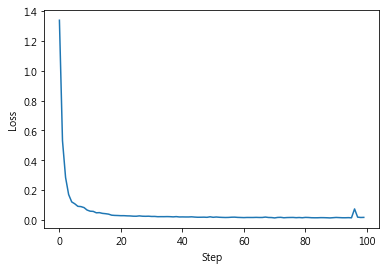

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(all_losses[:100])
plt.xlabel("Step")
plt.ylabel("Loss") 
plt.show()

In [13]:
# for one input
def easy_pad(easy_sent, easy_tar):
    easy_sent += [PAD_TAG for i in range(MAX_LEN-len(easy_sent))]
    easy_tar += [PAD_TAG for i in range(MAX_LEN-len(easy_tar))]
    
    return easy_sent, easy_tar

def easy_test(_input):
    _input = torch.unsqueeze(_input, 0).expand(128,100)
    return _input

def easy_output(output):
    output = output.view(128,100,5)[0].argmax(1)
    return output

In [14]:
test_content = readfile(test_data)
word_list_test, tag_list_test = split_to_list(test_content)

#===================================
easy_sent, easy_tar = easy_pad(word_list_test[3],tag_list_test[3])
input_test = prepare_sequence(easy_sent, word_to_ix)
# input_test = prepare_sequence(t_sentence, word_to_ix)

target_test = prepare_sequence(easy_tar, tag_to_ix)

_input = easy_test(input_test)

In [15]:
# Check predictions after training
with torch.no_grad():
    output = entity_typing(_input.cuda() if USE_CUDA else _input)
    output = easy_output(output)
    
    print('predict :', output)
    print('true :', target_test)
    

predict : tensor([ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  2,  3,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1], device='cuda:0')
true : tensor([ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  2,  3,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1])


In [16]:
def prepare_sequence__(seq, to_ix):
    gg = []
    
    for w in seq:
        if w not in to_ix:
            return seq

#     idxs = [to_ix[w] for w in seq]
#     return torch.tensor(idxs, dtype=torch.long)

def prepare_all__(seqs, to_ix):
    get_index = []
    notinseq = []
    for i in range(len(seqs)):
        a = prepare_sequence__(seqs[i], to_ix)
        if a != None:
            notinseq.append( a)
            get_index.append(i)
#         seq_list.append(prepare_sequence__(seqs[i], to_ix))
        
#     notinseq = torch.stack(notinseq)
        
    return notinseq, get_index



In [17]:
# for batch input
reserved_index_test = filter_len(word_list_test[:143])

In [18]:
len(reserved_index_test)

128

In [19]:
filter_word, filter_tag = filter_sentence(reserved_index_test, word_list_test, tag_list_test)
input_padded, target_padded = pad_all(filter_word, filter_tag)
input_var = prepare_all(input_padded, word_to_ix)
target_var = prepare_all(target_padded, tag_to_ix)

In [20]:
def total_output(output):
    output = output.view(BATCH_SIZE,MAX_LEN,tagset_size).argmax(2)
    return output

In [21]:
# Check predictions after training
with torch.no_grad():
    output = entity_typing(input_var.cuda() if USE_CUDA else _input)
    
    loss = criterion(output.cpu(), target_var.view(128*100))
    output = total_output(output)
    
    print('predict :', output[37])
    print('true :', target_var[37])
    print()
    print('predict :', index2tag(output[37], ix_to_tag))
    print('true :', index2tag(target_var[37], ix_to_tag))
    print()
    
    print("Loss : %.4f" % loss)

predict : tensor([ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  2,  3,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1], device='cuda:0')
true : tensor([ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1])

predict : ['O', 'O', 'O', 'O', 'O',

In [22]:
Variable(torch.Tensor([0] * 12))

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [75]:
encoder_sequence = Variable(torch.zeros([10, 1]))
encoder_sequence[1].cat(3)

AttributeError: 'Tensor' object has no attribute 'cat'

In [41]:
g = list(a)
torch.stack(g,0)

tensor([[[ 1.,  1.,  1.],
         [ 1.,  1.,  1.]],

        [[ 1.,  1.,  1.],
         [ 1.,  1.,  1.]]])